In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [35]:
from exp.dl_utils import *

In [3]:
MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'


In [4]:
def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train,y_train,x_valid,y_valid))

In [5]:
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))


In [6]:
def get_model(data, lr=0.5, nh=50):
    m = data.train_ds.x.shape[1]
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,data.c))
    return model, optim.SGD(model.parameters(), lr=lr)

In [26]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
nh,bs = 50,64
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [27]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [28]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

In [57]:
def accuracy2(out, yb): return 1


In [70]:
cbfs = [partial(AvgStatsCallback,[accuracy2,accuracy]),
        CudaCallback, 
        Recorder,
        partial(ParamScheduler, 'lr', sched),
        ProgressBarCallback,
       ]

In [71]:
opt_func = partial(Optimizer, steppers=[sgd_step])

In [72]:
model,_=get_model(data)

In [73]:
opt = opt_func(model.parameters(), lr=0.5)


In [74]:
learn = Learner(model,data,F.cross_entropy,cb_funcs=cbfs,opt_func=opt_func)


In [75]:
learn.fit(5)

epoch,train_loss,train_accuracy2,train_accuracy,valid_loss,valid_accuracy2,valid_accuracy,time
0,0.362906,1.000000,0.891440,0.191918,1.000000,0.943000,00:00
1,0.174233,1.000000,0.946840,0.502894,1.000000,0.863500,00:00
2,0.118767,1.000000,0.963540,0.146602,1.000000,0.960200,00:00
3,0.081418,1.000000,0.975060,0.100386,1.000000,0.971300,00:00
4,0.061457,1.000000,0.981620,0.101549,1.000000,0.971200,00:00


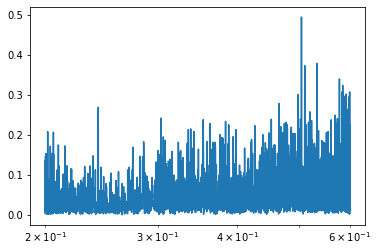

In [48]:
learn.recorder.plot(skip_last=5)

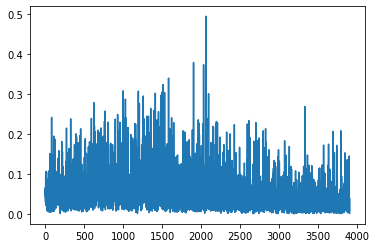

In [49]:
learn.recorder.plot_loss()

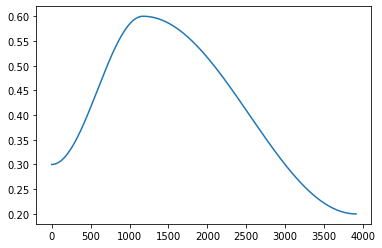

In [50]:
learn.recorder.plot_lr()